In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize, minmax_scale
from scipy.stats import pearsonr, spearmanr, f_oneway, norm
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/sibcb1/chenluonanlab8/caideyu/CauTrigger_new/')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import scanpy as sc
import torch
import torch.nn as nn
torch.cuda.set_device(0)
import re
from sklearn.preprocessing import FunctionTransformer

from CauTrigger.utils import set_seed, select_features
from CauTrigger.model import CauTrigger1L, CauTrigger2L

In [2]:
data_dir = '/sibcb1/chenluonanlab8/caideyu/CauTrigger_new/BenchmarkHESC/data/'
output_dir = '/sibcb1/chenluonanlab8/caideyu/CauTrigger_new/BenchmarkHESC/output/'
os.makedirs(output_dir, exist_ok=True)

In [3]:
set_seed(42)

In [15]:
Trrust = pd.read_table(os.path.join(data_dir, 'trrust_rawdata.human.tsv'), header=None)
Trrust_TF = Trrust.iloc[:, 0].dropna().unique()

In [86]:
TFs = pd.read_csv(data_dir + 'allTFs_hg38.txt', header=None)[0].values

array(['ZNF354C', 'KLF12', 'ZNF143', ..., 'ZNF831', 'ZRSR2', 'ZSWIM1'],
      dtype=object)

In [114]:
expData = pd.read_csv(os.path.join(data_dir, 'hESC_ExpressionData.csv'), index_col=0).transpose()
adata1 = sc.AnnData(X=expData, dtype=np.float32)
sc.pp.highly_variable_genes(adata1, n_top_genes=2000, flavor='cell_ranger')
adata1 = adata1[:, adata1.var.highly_variable]
hESC_pt = pd.read_csv(os.path.join(data_dir, 'hESC_PseudoTime.csv'), index_col=0)
hESC_pt['cell_type_1'] = np.where(hESC_pt.index.str.contains('00h'), 0, np.where(hESC_pt.index.str.contains('96h'), 1, np.nan))
adata1.obs = hESC_pt
adata1 = adata1[~np.isnan(adata1.obs['cell_type_1'].values), :]
adata1.obs['labels'] = adata1.obs['cell_type_1'].copy()  # 280 × 2000

In [118]:
model_1L = CauTrigger1L(
    adata1,
    n_latent=10,
    n_hidden=128,
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    dropout_rate_dpd=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=True,
    dpd_linear=False,
    init_weight=None,
    init_thresh=0.0,
    attention=False,
    att_mean=False,
    )
model_1L.train(max_epochs=300, stage_training=True, batch_size=32)

training: 100%|██████████| 300/300 [02:20<00:00,  2.13it/s]


In [119]:
df_layer1, _ = model_1L.get_up_feature_weights(method='SHAP', sort_by_weight=False)
topk_indices = df_layer1["weight"].values.argsort()[-1000:]
X_down = adata1[:, topk_indices]

In [121]:
all_indices = np.arange(adata1.shape[1])
other_indices = all_indices[~np.isin(all_indices, topk_indices)]

adata2 = adata1[:, other_indices]
adata2 = adata2[:, np.isin(adata2.var_names, TFs)]
adata2.obsm['X_down'] = X_down.X.copy()

In [122]:
model_2L = CauTrigger2L(
    adata2,
    n_latent=10,
    n_hidden=128,
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    dropout_rate_dpd=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=True,
    dpd_linear=True,
    init_weight=None,
    init_thresh=0.0,
    attention=False,
    att_mean=False,
)
model_2L.train(max_epochs=300, stage_training=True, batch_size=32)

training: 100%|██████████| 300/300 [02:09<00:00,  2.32it/s]


In [123]:
df_layer2, _ = model_2L.get_up_feature_weights(method='SHAP', sort_by_weight=True)

In [124]:
tftg_score = model_2L.get_2to1_ig()
tftg_score = tftg_score.mean(0)  # TF x TG
tftg_score_df = pd.DataFrame(tftg_score, index=adata2.var_names, columns=X_down.var_names)

In [ ]:
from CauTrigger.utils import set_seed
from CauTrigger.model import CauTrigger2L, CauTrigger3L
import anndata
set_seed(42)

expData = pd.read_csv(os.path.join(data_dir, 'hESC_ExpressionData.csv'), index_col=0).transpose()
adata = sc.AnnData(X=expData, dtype=np.float32)
sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor='cell_ranger')
hESC = adata[:, adata.var.highly_variable]
Trrust = pd.read_table(os.path.join(data_dir, 'trrust_rawdata.human.tsv'), header=None)
Trrust_TF = Trrust.iloc[:, 0].dropna().unique()
Trrust_nonTF = np.setdiff1d(Trrust.iloc[:, 1].dropna().unique(), Trrust_TF)
hESC_pt = pd.read_csv(os.path.join(data_dir, 'hESC_PseudoTime.csv'), index_col=0)
hESC_pt['cell_type_1'] = np.where(hESC_pt.index.str.contains('00h'), 0, np.where(hESC_pt.index.str.contains('96h'), 1, np.nan))
hESC_deg = pd.read_csv(os.path.join(data_dir, 'hESC_DEgenes_MAST_hvg1000_sp4.csv'), index_col=0)
hESC.obs = hESC_pt
start_TF = hESC[(hESC.obs['cell_type_1'] == 0), np.intersect1d(hESC.var_names, Trrust_TF)]
end_TF = hESC[(hESC.obs['cell_type_1'] == 1), np.intersect1d(hESC.var_names, Trrust_TF)]
start_down = hESC[(hESC.obs['cell_type_1'] == 0), np.intersect1d(hESC.var_names, Trrust_nonTF)]
end_down = hESC[(hESC.obs['cell_type_1'] == 1), np.intersect1d(hESC.var_names, Trrust_nonTF)]
adata2 = anndata.concat([start_TF.copy(), end_TF.copy()])
adata2.obs['labels'] = np.repeat([0, 1], [start_TF.shape[0], end_TF.shape[0]])
adata2.obsm['X_down'] = anndata.concat([start_down, end_down]).X.copy()
init_weight = pd.DataFrame({'gene': adata2.var_names})
mESC_deg1 = hESC_deg.copy()
mESC_deg1['gene'] = mESC_deg1.index
init_weight1 = pd.merge(init_weight, mESC_deg1, on='gene', how='left')
min_value = init_weight1['logFC'].min()
max_value = init_weight1['logFC'].max()
init_weight1['logFC'] = init_weight1['logFC'].apply(lambda x: (x - min_value) / (max_value - min_value) * 0.5 + 0.5 if pd.notnull(x) else x)
init_weight1['logFC'] = init_weight1['logFC'].fillna(0.5)
prior_probs = np.array(init_weight1['logFC'])
model2 = CauTrigger2L(
        adata2,
        n_causal=2,
        n_latent=10,
        n_hidden=256,
        n_layers_encoder=1,
        n_layers_decoder=1,
        n_layers_dpd=1,
        dropout_rate_encoder=0.5,
        dropout_rate_decoder=0.5,
        dropout_rate_dpd=0.5,
        use_batch_norm='none',
        use_batch_norm_dpd=True,
        decoder_linear=True,
        dpd_linear=False,
        init_weight=None,
        init_thresh=0.0,
        update_down_weight=False,
        attention=True,
        att_mean=False,
    )
model2.pretrain_attention(prior_probs=prior_probs, max_epochs=100)
model2.train(max_epochs=500, stage_training=True, im_factor=1)

In [337]:
weight_df_weight2 = model2.get_up_feature_weights(normalize=True, method="Grad", sort_by_weight=False)
causal_factors_layer2_indices = np.argsort(weight_df_weight2[0]['weight'])[-20:][::-1]
all_indices = np.arange(adata2.shape[1])
other_indices = all_indices[~np.isin(all_indices, causal_factors_layer2_indices)]
adata3 = adata2[:, other_indices]
adata3.obsm['X_down2'] = adata2.obsm['X_down'].copy()
adata3.obsm['X_down1'] = adata2.X[:, causal_factors_layer2_indices]
adata3.uns['TG_names'] = start_down.var_names
adata3.uns['TF2L_names'] = adata2[:, causal_factors_layer2_indices].var_names.values

In [338]:
model3 = CauTrigger3L(
    adata3,
    n_latent=10,
    n_hidden=128,
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    dropout_rate_dpd=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=False,
    dpd_linear=False,
    # update_down_weight=True,
    init_thresh=0.00,
    attention=False,
    att_mean=False,
    decoder_down2_sparse=False,
)

model3.train(max_epochs=500, stage_training=True, im_factor=1)

training: 100%|██████████| 500/500 [01:36<00:00,  5.19it/s]


In [354]:
tf2tf_ig = model2.get_2to1_ig()

In [360]:
tf2tf_ig_df = pd.DataFrame(tf2tf_ig.mean(0)[[adata2.var_names.get_loc(g) for g in TFdown1]], index=TFdown1, columns=start_down.var_names)

In [339]:
tftg_score = model3.get_3to2_ig()
tftg_score = tftg_score.mean(0)  # TF x TG
tftg_score_df = pd.DataFrame(tftg_score, index=adata3.var_names, columns=adata3.uns['TF2L_names'])

In [340]:
collectri = pd.read_csv(data_dir+'CollecTRI_source.tsv', sep='\t')

In [341]:
collectri_table = collectri['TF:TG'].str.split(':', expand=True)

In [342]:
TFup = adata3.var_names
TFdown = adata3.uns['TF2L_names']

gt = []
for up in TFup:
    for down in TFdown:
        if ((collectri_table[0] == up) & (collectri_table[1] == down)).any():
            gt.append((up, down))  # up regulates down
        if ((collectri_table[0] == down) & (collectri_table[1] == up)).any():
            gt.append((down, up))  # down regulates up
            
import itertools
TFup1 = TFup[np.isin(TFup, list(itertools.chain(*gt)))]
TFdown1 = TFdown[np.isin(TFdown, list(itertools.chain(*gt)))]

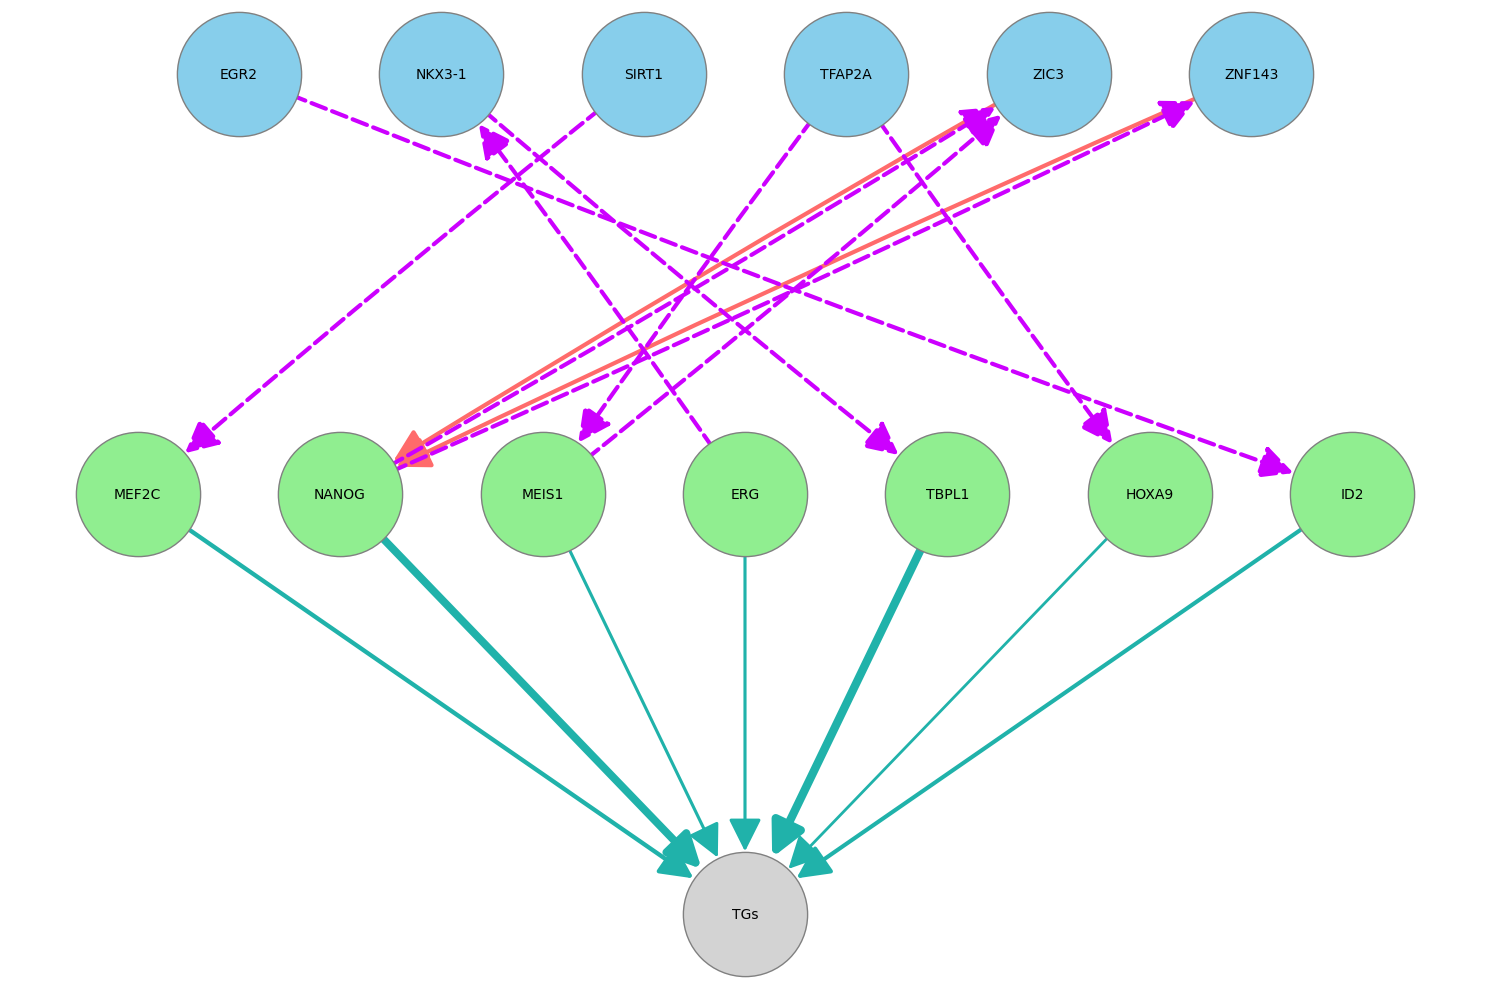

In [417]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

G = nx.DiGraph()

for tf in TFup1:
    G.add_node(tf, layer=0)
for tf in TFdown1:
    G.add_node(tf, layer=1)

G.add_node('TGs', layer=2)

edge_weights = []
for up in TFup1:
    for down in TFdown1:
        score = tftg_score_df.loc[up, down]
        if score != 0 and abs(score) > 0.12629945500107864:

            G.add_edge(up, down, weight=abs(score))


for down in TFdown1:
    score1 = tf2tf_ig_df.loc[down, :].mean()
    G.add_edge(down, 'TGs', weight=score1)

missing_gt = [(u, v) for u, v in gt if not G.has_edge(u, v)]

plt.figure(figsize=(15, 10))

COLORS = {
    'node': {
        'TFup': '#87CEEB',
        'TFdown': '#90EE90',
        'TGs': '#D3D3D3'
    },
    'edge': {
        'positive': '#FF6B6B',
        'negative': '#FF6B6B',
        'missing': '#CC00FF'
    }
}

def get_centered_pos(nodes, layer_height, base_spacing=1.0):
    n = len(nodes)
    if n == 0:
        return {}
    
    total_width = (n - 1) * base_spacing
    start_x = -total_width / 2
    
    return {
        node: (start_x + i * base_spacing, layer_height)
        for i, node in enumerate(nodes)
    }

pos = {}
pos.update(get_centered_pos(TFup1, layer_height=1, base_spacing=1.0))
pos.update(get_centered_pos(TFdown1, layer_height=0.5, base_spacing=1.0))
pos.update(get_centered_pos(['TGs'], layer_height=0, base_spacing=1.0))

nx.draw_networkx_nodes(G, pos, nodelist=TFup1, node_color=COLORS['node']['TFup'], 
                       node_size=8000, edgecolors='gray', label='TFup')
nx.draw_networkx_nodes(G, pos, nodelist=TFdown1, node_color=COLORS['node']['TFdown'], 
                       node_size=8000, edgecolors='gray', label='TFdown')
nx.draw_networkx_nodes(G, pos, nodelist=['TGs'], node_color=COLORS['node']['TGs'], 
                       node_size=8000, edgecolors='gray', label='TGs')


gt_edges = [(u, v) for u, v in gt if G.has_edge(u, v)]
non_gt_edges = [e for e in G.edges() if e not in gt and (e[1], e[0]) not in gt]
tg_edges = [(u, 'TGs') for u in TFdown1]

nx.draw_networkx_edges(
    G, pos, edgelist=gt_edges,
    edge_color=[COLORS['edge']['positive'] if G.edges[u,v]['weight'] > 0 else COLORS['edge']['negative'] 
               for u,v in gt_edges],
    style='solid', width=3, alpha=1,
    arrows=True, arrowstyle='-|>', arrowsize=50, min_source_margin=45, min_target_margin=45,connectionstyle='arc3,rad=0.01'
)


nx.draw_networkx_edges(
    G, pos, edgelist=missing_gt,
    edge_color=COLORS['edge']['missing'],
    style='dashed', width=3, alpha=1,
    arrows=True, arrowstyle='-|>', arrowsize=50, min_source_margin=0, min_target_margin=45,connectionstyle='arc3,rad=0.01'
)



tg_edge_widths = [G.edges[u, v]['weight'] for u, v in tg_edges]

if len(tg_edge_widths) > 0:
    w_min, w_max = min(tg_edge_widths), max(tg_edge_widths)
    if w_max != w_min:
        tg_edge_widths = [2 + 4 * (w - w_min) / (w_max - w_min) for w in tg_edge_widths]
    else:
        tg_edge_widths = [3 for _ in tg_edge_widths]

nx.draw_networkx_edges(
    G, pos, edgelist=tg_edges,
    edge_color='#20B2AA',
    style='solid', width=tg_edge_widths, alpha=1,
    arrows=True, arrowstyle='-|>', arrowsize=50, min_source_margin=0, min_target_margin=45
)

nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.axis('off')
plt.tight_layout()
plt.show()